In [1]:
import numpy as np
import pandas as pd
from surprise import Reader, Dataset
from tqdm import tqdm
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from collections import defaultdict
from math import log2
from sklearn.utils import resample
tqdm.pandas()
from surprise import NMF

In [2]:
# Load and filter data
interactions = pd.read_pickle('../Pickle/interactions.pkl')
books = pd.read_pickle('../Pickle/books.pkl')
interactions = interactions[['user_id', 'book_id', 'rating', 'is_read']]  

In [3]:
# Step 1: Compute the average rating per user (excluding 0s) and round to the nearest whole number
user_avg_rating = interactions[interactions['rating'] > 0].groupby('user_id')['rating'].mean().round().astype(int)

# Step 2: Round the book's average rating column
books['average_rating'] = pd.to_numeric(books['average_rating'], errors='coerce').round().astype('Int64')
book_avg = books[['average_rating', 'book_id']]
interactions = pd.merge(interactions, book_avg, on = 'book_id')

# Step 3: Replace 0 ratings with the user's average rating or the book's average rating if the user has no ratings
def impute_rating(row):
    if row['rating'] == 0:
        return user_avg_rating.get(row['user_id'], row['average_rating'])  # Use user avg or book avg
    return row['rating']

# Apply the function
interactions['rating'] = interactions.apply(impute_rating, axis=1)


In [4]:
# Filter user IDs that appear more than 5 times
# Filter book IDs that appear more than 5 times
book_counts = interactions['book_id'].value_counts()
interactions = interactions[interactions['book_id'].isin(book_counts[book_counts >= 5].index)]
user_counts = interactions['user_id'].value_counts()
interactions = interactions[interactions['user_id'].isin(user_counts[user_counts >= 5].index)]

# Shuffle user interactions
# Initialize empty lists for train and test splits
train_list, test_list = [], []

for user_id, user_data in interactions.groupby('user_id'):
    # Shuffle the ratings for the user
    user_data_shuffled = user_data.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Split the data into train and test (80% for train, 20% for test)
    train, test = train_test_split(user_data_shuffled, test_size=0.2, random_state=42, stratify=user_data_shuffled['user_id'])
    
    # Add the train and test data for this user to the overall list
    train_list.append(train)
    test_list.append(test)

# Concatenate all train and test data
train_df = pd.concat(train_list, ignore_index=True)
test_df = pd.concat(test_list, ignore_index=True)


In [5]:
# Get rating counts
rating_counts = train_df['rating'].value_counts()

# Find the majority class size (highest count)
majority_count = rating_counts.max()

# Dictionary to store oversampled dataframes
oversampled_dfs = []

# Perform upsampling for each class to match a proportion of the majority count
for rating, count in rating_counts.items():
    class_df = train_df[train_df['rating'] == rating]
    
    # Upsample based on a percentage of the majority class size
    if count < majority_count:
        upsampled_df = resample(class_df, replace=True, n_samples=int(majority_count * 0.8), random_state=42)
    else:
        upsampled_df = class_df  # Keep majority class as is
    
    oversampled_dfs.append(upsampled_df)

# Combine all upsampled data
balanced_train = pd.concat(oversampled_dfs)

# Shuffle dataset
train_df = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
# Convert standardized train_df to surprise dataset
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
train_data = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)

# Convert test_df to surprise dataset without normalization
test_data = Dataset.load_from_df(test_df[['user_id', 'book_id', 'rating']], reader)

# Build full trainset and testset
trainset = train_data.build_full_trainset()
testset = test_data.construct_testset([(uid, iid, r, {}) for uid, iid, r in test_df[['user_id', 'book_id', 'rating']].values])

In [7]:
# Define the parameter grid
param_grid = { 
    'n_factors': [400,300],  
    'n_epochs': [250, 150],  
    'reg_pu': [0.1, 0.01],  # Regularization for user factors
    'reg_qi': [0.1, 0.01],  # Regularization for item factors
    'lr_bu': [0.01, 0.1],  # Learning rate for user bias
    'lr_bi': [0.01, 0.1],  # Learning rate for item bias
    'random_state': [42]
}

# Define the grid search with GridSearchCV
gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=2)

# Fit the grid search model
gs.fit(train_data)

# Get the best parameters and model
best_params = gs.best_params['rmse']
best_nmf = NMF(**best_params)
best_nmf.fit(train_data.build_full_trainset())

# Test the model
predictions = best_nmf.test(testset)

In [8]:
import joblib
joblib.dump(best_nmf, 'best_nmf_model.pkl')

['best_nmf_model.pkl']

In [9]:
best_params

{'n_factors': 300,
 'n_epochs': 250,
 'reg_pu': 0.01,
 'reg_qi': 0.01,
 'lr_bu': 0.01,
 'lr_bi': 0.01,
 'random_state': 42}

In [10]:
# Evaluation metrics: Precision, Recall, and nDCG at k
def precision_recall_ndcg_at_k(predictions, k, threshold):
    """Return precision, recall, and nDCG at k metrics for each user."""
    
    def dcg_at_k(scores, k):
        return sum([rel / log2(idx + 2) for idx, rel in enumerate(scores[:k])])

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    ndcgs = dict()
    
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        
        # Precision@K
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        
        # Recall@K
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
        
        # nDCG@K
        actual = [true_r for (_, true_r) in user_ratings]
        ideal = sorted(actual, reverse=True)
        
        idcg = dcg_at_k(ideal, k)
        dcg = dcg_at_k([rel for (est, rel) in user_ratings], k)
        ndcgs[uid] = dcg / idcg if idcg > 0 else 0
    
    precision = sum(prec for prec in precisions.values()) / len(precisions)
    recall = sum(rec for rec in recalls.values()) / len(recalls)
    ndcg = sum(ndcg for ndcg in ndcgs.values()) / len(ndcgs)
    
    return precision, recall, ndcg

# Compute the evaluation metrics
precision, recall, ndcg = precision_recall_ndcg_at_k(predictions, k=10, threshold=3.5)
print(f'Adjusted Precision: {precision}, Adjusted Recall: {recall}, Adjusted nDCG: {ndcg}')


Adjusted Precision: 0.7937471194439827, Adjusted Recall: 0.7924777086364793, Adjusted nDCG: 0.9639702529269795


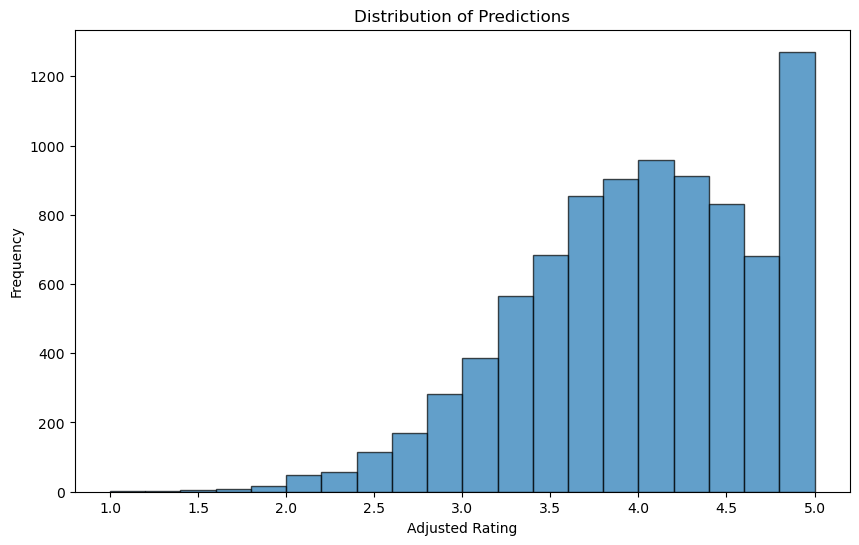

In [11]:
import matplotlib.pyplot as plt

# Extract the adjusted predictions
rating_values = [pred[3] for pred in predictions] 

# Plot the distribution of adjusted ratings
plt.figure(figsize=(10, 6))
plt.hist([pred[3] for pred in predictions], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Predictions')
plt.xlabel('Adjusted Rating')
plt.ylabel('Frequency')
plt.show()

In [12]:
# Load the model from the file
loaded_nmf = joblib.load('best_nmf_model.pkl')

In [13]:
from tqdm import tqdm

def recommend_books(model, interactions, user_id=None, n_recommendations=5):
    """Recommend top-N books for a specific user or all users using the trained NMF model."""
    
    # Get unique books from the interactions dataset
    all_books = interactions['book_id'].unique()

    # If a specific user is provided, recommend for that user only
    if user_id:
        user_predictions = [
            (book_id, model.predict(uid=user_id, iid=book_id).est) for book_id in all_books
        ]
        user_predictions.sort(key=lambda x: x[1], reverse=True)
        
        return {user_id: user_predictions[:n_recommendations]}  # Return (book_id, predicted_rating)
    
    # If no specific user is provided, generate recommendations for all users
    all_users = interactions['user_id'].unique()
    recommendations = {}

    for uid in tqdm(all_users, desc="Generating Recommendations"):
        user_predictions = [
            (book_id, model.predict(uid=uid, iid=book_id).est) for book_id in all_books
        ]
        user_predictions.sort(key=lambda x: x[1], reverse=True)

        recommendations[uid] = user_predictions[:n_recommendations]  # Return (book_id, predicted_rating)

    return recommendations


In [14]:
interactions['user_id'].value_counts()

user_id
1431    168
1488    167
1500    155
1463    151
495     147
       ... 
1348      5
480       5
265       5
1752      5
850       5
Name: count, Length: 1722, dtype: int64

In [15]:
user_id = 1431
recommended_books = recommend_books(loaded_nmf, interactions, user_id=user_id, n_recommendations=5)
print(f"Recommendations for User {user_id}: {recommended_books[user_id]}")


Recommendations for User 1431: [(427, 5), (704, 5), (912, 5), (941, 5), (1063, 5)]


In [16]:
user_id = 495
recommended_books = recommend_books(loaded_nmf, interactions, user_id=user_id, n_recommendations=5)
print(f"Recommendations for User {user_id}: {recommended_books[user_id]}")


Recommendations for User 495: [(103, 5), (104, 5), (245, 5), (272, 5), (427, 5)]


In [17]:
user_id = 1643       
recommended_books = recommend_books(loaded_nmf, interactions, user_id=user_id, n_recommendations=5)
print(f"Recommendations for User {user_id}: {recommended_books[user_id]}")


Recommendations for User 1643: [(68, 3.0476281670720264), (100, 3.0476281670720264), (103, 3.0476281670720264), (104, 3.0476281670720264), (234, 3.0476281670720264)]


In [18]:
user_id = 1228
recommended_books = recommend_books(loaded_nmf, interactions, user_id=user_id, n_recommendations=5)
print(f"Recommendations for User {user_id}: {recommended_books[user_id]}")


Recommendations for User 1228: [(68, 3.0476281670720264), (100, 3.0476281670720264), (103, 3.0476281670720264), (104, 3.0476281670720264), (234, 3.0476281670720264)]


In [19]:
user_id = 1120
recommended_books = recommend_books(loaded_nmf, interactions, user_id=user_id, n_recommendations=5)
print(f"Recommendations for User {user_id}: {recommended_books[user_id]}")


Recommendations for User 1120: [(68, 3.0476281670720264), (100, 3.0476281670720264), (103, 3.0476281670720264), (104, 3.0476281670720264), (234, 3.0476281670720264)]
